In [9]:
%cd /users/anglos/Developer/psiphi

/auto/users/anglos/Developer/psiphi


In [10]:
#@title Imports
import jax
import tree

import social_rl

In [11]:
#@title Constants, experiment config.
GOALS_COLORS = ['green', 'red']
NUM_LEARNING_STEPS = 10_000
BATCH_SIZE = 64
DATA_DIR = 'data'
EXPERT_EPSILON = 0.1

In [12]:
#@title Collect expert data: Run this only once!
if False:
  for GOAL_COLOR in GOALS_COLORS:
    !/scratch/anglos/conda_envs/psiphi/bin/python experiments/collect_rollouts.py \
      -config=experiments/configs/collect_rollouts.py:{GOAL_COLOR} \
      --config.num_rollouts=500 \
      --config.epsilon={EXPERT_EPSILON}

In [13]:
#@title Initialise environment, agent and offline dataset.
env = social_rl.GridWorld(goal_color=GOALS_COLORS[0])
replay_buffer_0 = social_rl.replay.DemonstrationsBuffer(
    batch_size=BATCH_SIZE,
    data_dir='{}/{}/{}'.format(
      DATA_DIR, GOALS_COLORS[0], EXPERT_EPSILON),
    seed=42)
replay_buffer_1 = social_rl.replay.DemonstrationsBuffer(
    batch_size=BATCH_SIZE,
    data_dir='{}/{}/{}'.format(
      DATA_DIR, GOALS_COLORS[1], EXPERT_EPSILON),
    seed=42)
for evaluation in (True, False):
  for replay_buffer in (replay_buffer_0, replay_buffer_1):
    assert replay_buffer.can_sample(evaluation)
assert len(GOALS_COLORS) == 2
agent_config = social_rl.agents.itd.get_config()
agent_config.num_demonstrators = 2
agent = social_rl.agents.ITDAgent(env, config=agent_config)

100%|██████████| 500/500 [00:01<00:00, 498.60it/s]


100%|██████████| 10000/10000 [01:14<00:00, 133.75it/s]
/auto/users/anglos/Developer/psiphi/social_rl/plotting.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


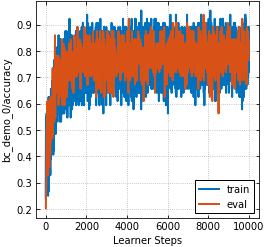

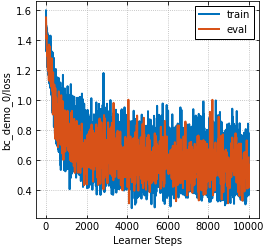

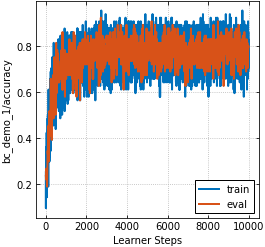

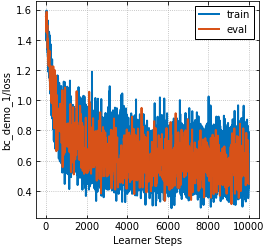

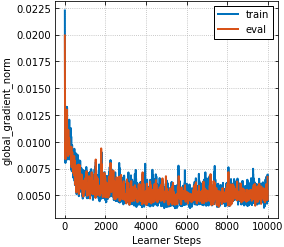

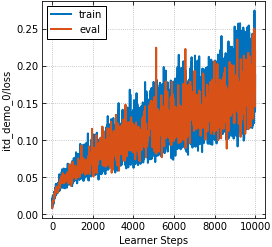

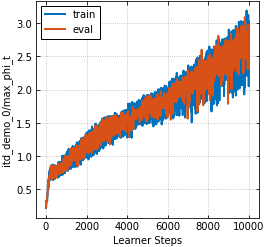

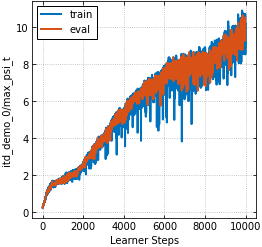

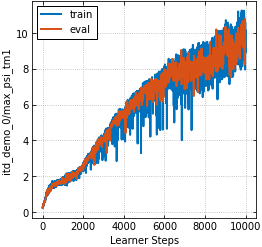

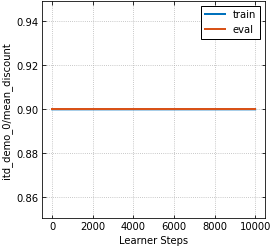

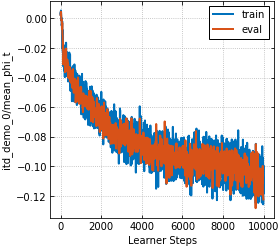

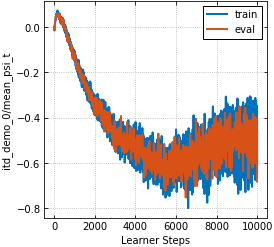

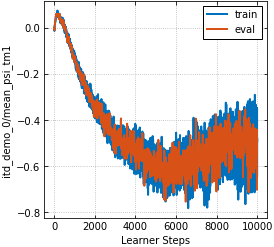

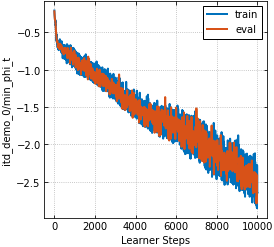

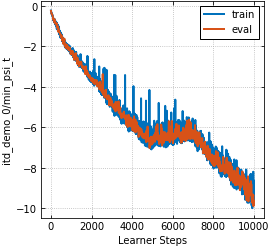

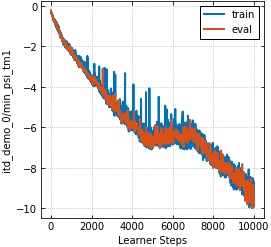

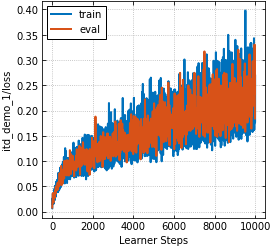

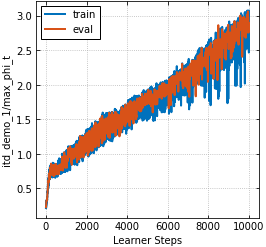

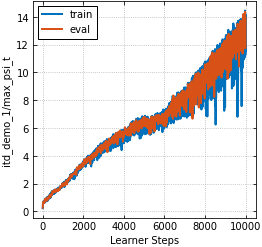

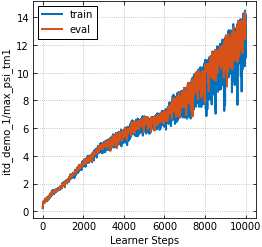

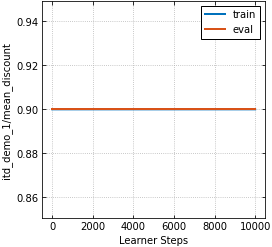

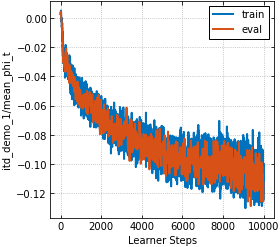

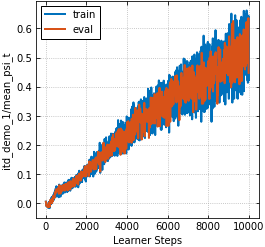

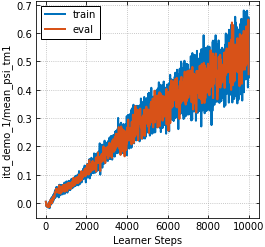

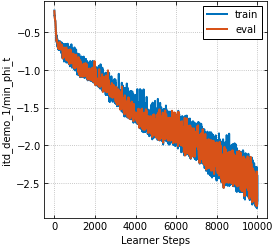

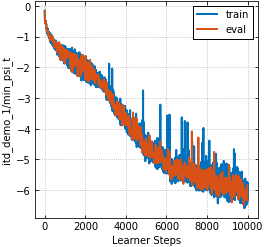

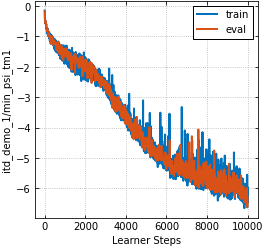

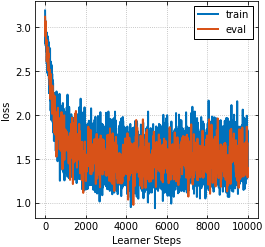

In [14]:
#@title Train agent on offline dataset.
learner_buffer_loop = social_rl.loops.LearnerBufferLoop(
    [replay_buffer_0, replay_buffer_1], agent)
rng_key = jax.random.PRNGKey(42)
rng_key, learner_key = jax.random.split(rng_key, num=2)
params, learner_state, learner_stats = learner_buffer_loop.run(
    learner_key, num_iterations=NUM_LEARNING_STEPS, evaluate_every=10)
social_rl.plotting.plot_learner_buffer_loop_stats(learner_stats);

In [ ]:
#@title Evaluate agent online.
def evaluate(env: social_rl.GridWorld) -> float:
  """Return the success rate on `env`."""
  actor_env_loop = social_rl.loops.ActorEnvironmentLoop(env, agent)
  _, actor_stats = actor_env_loop.run(
    jax.random.PRNGKey(42), num_iterations=500, params=params, evaluation=False)
  return actor_stats['returns'].sum() / len(actor_stats['returns'])

environments = {
    goal_color: social_rl.GridWorld(goal_color=goal_color, seed=42)
    for goal_color in ('red', 'green', 'blue')
}
tree.map_structure(evaluate, environments)